# Neural Networks: Part-3 Optimizing Model with Momentum


## Building Model with Momentum

A 3 Layer Neural Network

Model Structure is
**LINEAR -> RELU ->| LINEAR -> RELU ->| LINEAR -> SIGMOID**

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io
import math

###### Helper Functions

In [13]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s
#################################################
def relu(x):
    s = np.maximum(0,x)
    return s
#################################################
def initialize_parameters(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
           
    return parameters
#################################################
def forward_propagation(X, parameters):
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache
#################################################
def backward_propagation(X, Y, cache):
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients
#################################################
def update_parameters(parameters, grads, learning_rate):
    n = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for k in range(n):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
        
    return parameters

#################################################
def compute_cost(a3, Y):
    m = Y.shape[1]
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
    return cost
#################################################
def predict(parameters, X):
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions

#################################################
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.Spectral)
    plt.show()
    

##### Helper functions for Gradient Updates with Momentum

In [14]:
def initialize_velocity(parameters):   
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    # Initialize velocity
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape) 
    return v
#################################################
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural networks
    # Momentum update for each parameter
    for l in range(L):
        # compute velocities
        v["dW" + str(l+1)] = beta * v["dW" + str(l+1)] + (1 - beta) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta * v["db" + str(l+1)] + (1 - beta) * grads["db" + str(l+1)]
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v["db" + str(l+1)]
        
    return parameters, v
#################################################
def initialize_RMS(parameters) :
    L = len(parameters) // 2 # number of layers in the neural networks
    s = {}
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
    return v, s
#################################################
def update_parameters_with_RMS(parameters, grads, v, s, t, learning_rate = 0.01,beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):    
    L = len(parameters) // 2                 # number of layers in the neural networks
    
    # Perform Adam update on all parameters
    for l in range(L):
       
        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1 - beta2) * (grads["dW" + str(l+1)] * grads["dW" + str(l+1)])
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1 - beta2) * (grads["db" + str(l+1)] * grads["db" + str(l+1)])

        
        # Update parameters. Inputs: "parameters, learning_rate, , s, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)] / (np.sqrt(s["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)] / (np.sqrt(s["db" + str(l+1)]) + epsilon)

    return parameters, v, s
#################################################
def initialize_adam(parameters) :
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
    return v, s
#################################################
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads["db" + str(l+1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1 - beta1)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1 - beta1)

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1 - beta2) * (grads["dW" + str(l+1)] * grads["dW" + str(l+1)])
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1 - beta2) * (grads["db" + str(l+1)] * grads["db" + str(l+1)])

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1 - beta2)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1 - beta2)

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_corrected["dW" + str(l+1)] / (np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)] / (np.sqrt(s_corrected["db" + str(l+1)]) + epsilon)

    return parameters, v, s

##### Helper functions for Mini Batch Processing

In [15]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### Model

Model that supports different optimization algorithms
- Mini-batch **Gradient Descent**: 
    - `random_mini_batches()` and `update_parameters()`
- Mini-batch **Momentum**:
    - `initialize_velocity()` and `update_parameters_with_momentum()`  
- Mini-batch **Adam**: it will call your functions:
    - `initialize_adam()` and `update_parameters_with_adam()`

In [16]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

# Data Generator

In [17]:
def load_dataset(dataset = "noisy_moons"):  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    
    
    datasets = {"noisy_circles": noisy_circles,"noisy_moons": noisy_moons,
                "blobs": blobs,"gaussian_quantiles": gaussian_quantiles}
    
    if (dataset=="planar"):
        np.random.seed(1)
        m = 400 # number of examples
        N = int(m/2) # number of points per class
        D = 2 # dimensionality
        X = np.zeros((m,D)) # data matrix where each row is a single example
        Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
        a = 4 # maximum ray of the flower

        for j in range(2):
            ix = range(N*j,N*(j+1))
            t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
            r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
            X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
            Y[ix] = j

        X = X.T
        Y = Y.T
    else:
        X, Y = datasets[dataset]
        X, Y = X.T, Y.reshape(1, Y.shape[0])

    # make blobs binary
    if dataset == "blobs":
        Y = Y%2
        
    return  X, Y

## Load and Visualize Dataset

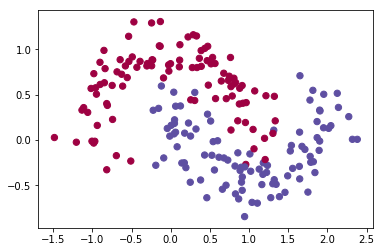

In [28]:
np.random.seed(3) # set a seed so that the results are consistent
#Options for dataset "planar","noisy_circles","noisy_moons","blobs","gaussian_quantiles"
train_X, train_Y = load_dataset("noisy_moons") 

# Visualize the data:
plt.scatter(train_X[0, :].flatten(), train_X[1, :].flatten(), c=train_Y.flatten(), 
            s=40, cmap=plt.cm.Spectral);


# Mini-batch Gradient descent

Cost after epoch 0: 0.711260
Cost after epoch 1000: 0.707705
Cost after epoch 2000: 0.646713
Cost after epoch 3000: 0.689511
Cost after epoch 4000: 0.595382
Cost after epoch 5000: 0.608290
Cost after epoch 6000: 0.627725
Cost after epoch 7000: 0.587012
Cost after epoch 8000: 0.534108
Cost after epoch 9000: 0.409336


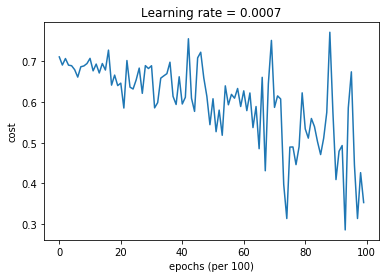

On the training set:
train accuracy: 80.5 %


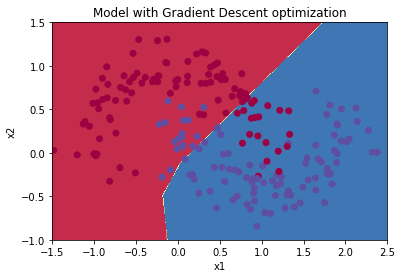

In [29]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(parameters,train_X)
print ("On the training set:")
print("train accuracy: {} %".format(100 - np.mean(np.abs(predictions - train_Y)) * 100))

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y)

# Mini-batch gradient descent with momentum


Cost after epoch 0: 0.711257
Cost after epoch 1000: 0.707724
Cost after epoch 2000: 0.646775
Cost after epoch 3000: 0.689535
Cost after epoch 4000: 0.595528
Cost after epoch 5000: 0.608394
Cost after epoch 6000: 0.628148
Cost after epoch 7000: 0.586931
Cost after epoch 8000: 0.534347
Cost after epoch 9000: 0.409757


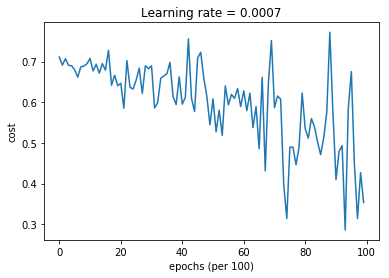

On the training set:
train accuracy: 80.0 %


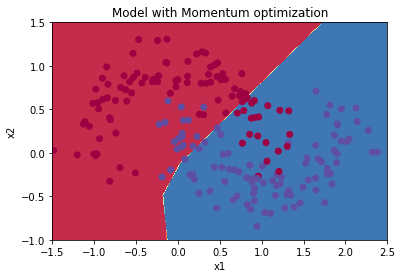

In [30]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(parameters,train_X)
print ("On the training set:")
print("train accuracy: {} %".format(100 - np.mean(np.abs(predictions - train_Y)) * 100))

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y)

# Mini-batch with Adam mode


Cost after epoch 0: 0.711002
Cost after epoch 1000: 0.561940
Cost after epoch 2000: 0.144887
Cost after epoch 3000: 0.259196
Cost after epoch 4000: 0.062844
Cost after epoch 5000: 0.071334
Cost after epoch 6000: 0.105065
Cost after epoch 7000: 0.266393
Cost after epoch 8000: 0.185609
Cost after epoch 9000: 0.031548


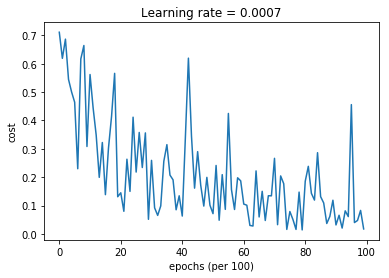

On the training set:
train accuracy: 98.0 %


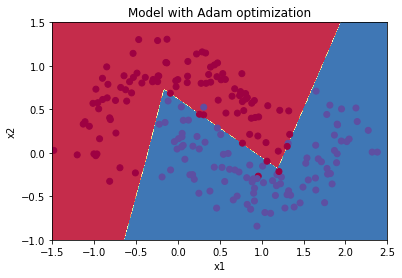

In [31]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(parameters,train_X)
print ("On the training set:")
print("train accuracy: {} %".format(100 - np.mean(np.abs(predictions - train_Y)) * 100))

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y)

# Summary

Momentum usually helps, but given the small learning rate and the simplistic dataset, its impact is almost negligeable. Also, the huge oscillations you see in the cost come from the fact that some minibatches are more difficult thans others for the optimization algorithm.

Adam on the other hand, clearly outperforms mini-batch gradient descent and Momentum. If you run the model for more epochs on this simple dataset, all three methods will lead to very good results. However, you've seen that Adam converges a lot faster.

Some advantages of Adam include:
- Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum) 
- Usually works well even with little tuning of hyperparameters (except $\alpha$)